Tamari Matikashvili

Matricola N. 2121549

14/01/2025

Models used: DBN and CNN


# Import Libraries

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}




In [2]:
%%capture
get_dbn_library()

In [3]:
%%capture
pip install optuna

In [4]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

In [56]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [6]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


True
cuda


# Data
Fashion MNIST dataset


In [7]:
%%capture
mnist_tr = tv.datasets.FashionMNIST(root="../fashion_mnist", train=True, download=True)
mnist_te = tv.datasets.FashionMNIST(root="../fashion_mnist", train=False, download=True)

In [8]:
# Normalization
mnist_tr.data = mnist_tr.data / 255
mnist_te.data = mnist_te.data / 255

In [9]:
mnist_tr.data = mnist_tr.data.to(device)
mnist_te.data = mnist_te.data.to(device)
mnist_tr.targets = mnist_tr.targets.to(device)
mnist_te.targets = mnist_te.targets.to(device)

In [10]:
#Check classes
unique_classes = torch.unique(mnist_te.targets)
print(f"Unique classes: {unique_classes}")


Unique classes: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


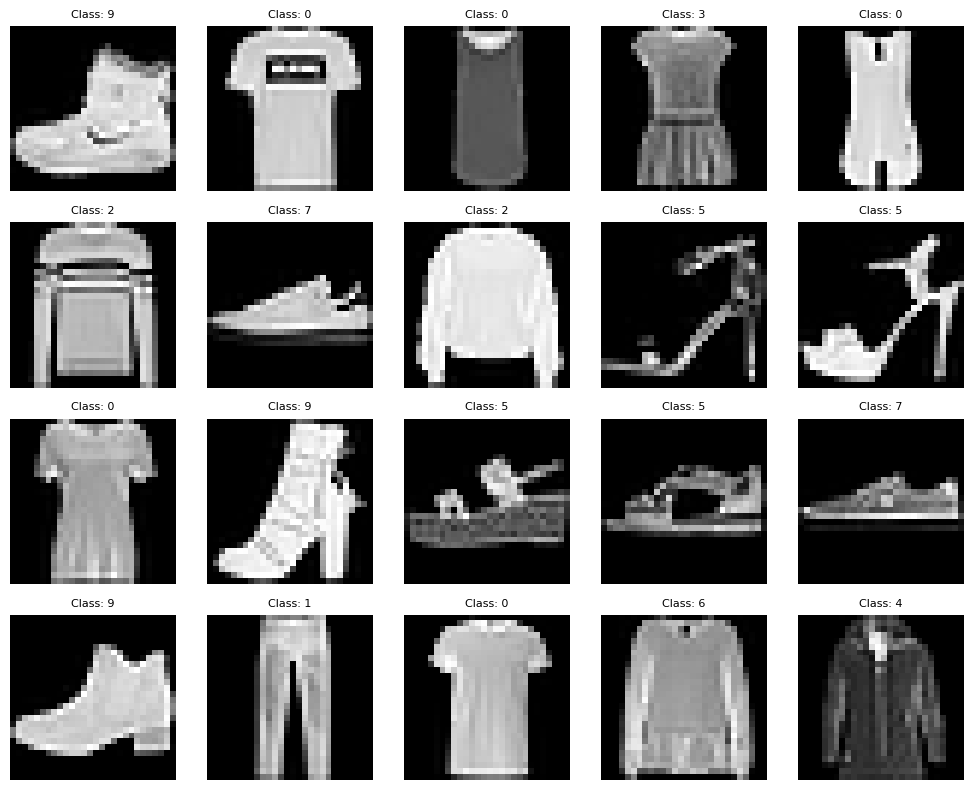

In [12]:
def plot_multiple_images(dataset, num_images=20, images_per_row=5):
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 2 * num_rows))
    for i in range(num_rows * images_per_row):
        row, col = divmod(i, images_per_row)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        if i < num_images:
            img = dataset.data[i].cpu()  # Move back from GPU memory for plotting
            label = dataset.targets[i].item()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Class: {label}", fontsize=8)
        else:
            ax.axis('off')  # Hide empty plots
    plt.tight_layout()
    plt.show()


plot_multiple_images(mnist_tr, num_images=20, images_per_row=5)


# DBN
In this part of I'am using the DBN introduced during the lab practices. This DBN is composed of 3 stacked Restricted Boltzmann Machines that are trained layer by layer with unsupervised learning. The layers learn hyerarchical features and each consecutive layer captures increasingly complex patterns in the data.

## Hyperparameter tuning
I train the DBN using Optuna library for hyperparameter tuning. It tries out different combinations of hyperparameters to improve the model's accuracy. It uses Bayesian optimization to make smart guesses about which settings might work best.

In [ ]:
# as the DBN only learns high level representations of the data through its layers but doesnt map those representations to output classes,
# I needed to add the LinearClassifier to compute accuracies and find the best parameters
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

def compute_accuracy(predictions, targets):
    return (predictions == targets).float().mean().item() * 100

# Define a function to extract hidden representations
def get_hidden_representations(dbn, data):
    """
    Passes data through the DBN to extract hidden representations.
    """
    hidden_repr = data.view(data.shape[0], -1).type(torch.FloatTensor).to(data.device)
    for i, layer in enumerate(dbn.rbm_layers):
        hidden_repr, _ = layer.to_hidden(hidden_repr)
        print(f"Layer {i+1} hidden representation mean: {hidden_repr.mean().item()}, std: {hidden_repr.std().item()}")
    return hidden_repr

# Objective function for Optuna
def objective(trial):
    """
    Objective function for Optuna to optimize DBN hyperparameters.
    """
    # Suggest hyperparameters
    lr_dbn = trial.suggest_loguniform("lr_dbn", 0.001, 0.1)
    hidden_units = trial.suggest_categorical("hidden_units", [[300, 400, 500], [400, 500, 800], [500, 600, 900]])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    k = trial.suggest_int("k", 1, 5)
    lr_classifier = trial.suggest_loguniform("lr_classifier", 0.001, 0.01)
    epochs_dbn = 30  # Fixed number of epochs for DBN
    epochs_classifier = 10  # Fixed number of epochs for classifier
    batch_size = 125  # Fixed batch size

    # Debugging: Log the hyperparameter values
    print(f"Trial parameters: lr_dbn={lr_dbn}, hidden_units={hidden_units}, weight_decay={weight_decay}, k={k}, lr_classifier={lr_classifier}")

    # Initialize and train the DBN
    dbn = DBN(
        visible_units=28 * 28,
        hidden_units=hidden_units,
        k=k,
        learning_rate=lr_dbn,
        weight_decay=weight_decay,
        learning_rate_decay=False,
        initial_momentum=0.5,
        final_momentum=0.95,
        xavier_init=False,
        increase_to_cd_k=False,
        use_gpu=torch.cuda.is_available(),
    )
    print("Training DBN...")
    dbn.train_static(mnist_tr.data, mnist_tr.targets, epochs_dbn, batch_size)

    # Extract hidden representations
    print("Extracting hidden representations...")
    train_hidden = get_hidden_representations(dbn, mnist_tr.data)
    test_hidden = get_hidden_representations(dbn, mnist_te.data)

    # Train the classifier
    print("Training linear classifier...")
    classifier = LinearClassifier(input_size=hidden_units[-1], num_classes=10).to(train_hidden.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr_classifier)
    train_dataset = TensorDataset(train_hidden, mnist_tr.targets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_classifier):
        total_loss = 0
        for batch_hidden, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = classifier(batch_hidden)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Classifier Epoch {epoch+1}/{epochs_classifier}, Loss: {total_loss:.4f}")

    # Evaluate the classifier on the test dataset
    print("Evaluating on the test dataset...")
    with torch.no_grad():
        test_outputs = classifier(test_hidden)
        predictions = test_outputs.argmax(dim=1)
        accuracy = compute_accuracy(predictions, mnist_te.targets)

    # Debugging: Log accuracy for the trial
    print(f"Trial Accuracy: {accuracy:.2f}%")
    return accuracy

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best Accuracy:", study.best_value)



The accuracy is lower on the Fashion MNIST dataset compared to the digits MNIST dataset seen during the labs because Fashion MNIST is more challenging. Unlike Digits MNIST, which has simple, clear shapes of handwritten numbers, Fashion MNIST features grayscale images of clothing items with more complex textures,blurry edges and subtle differences. This makes it harder for DBNs to pick up the detailed patterns needed to tell the clothing items apart.

Unfortunately, I ran the hyperparamater tuning code in another notebook, and it took more than a hour, So I didn't run the code again because I had stored the values of best paramateres in the "best_params" variable

## Training
Each RBM is trained individually in a layer-wise manner using Contrastive Divergence.

In [13]:
# best hyperparameters from the Optuna study
best_params = {
    'lr_dbn': 0.04885164470650792,
    'hidden_units': [500, 600, 900],
    'weight_decay': 1.1520142025646767e-05,
    'k': 4,
    'lr_classifier': 0.0015465460491695272
}


print("Best Hyperparameters:", best_params)

# Use the best parameters to train the DBN again
dbn = DBN(
    visible_units=28 * 28,
    hidden_units=best_params["hidden_units"],
    k=best_params["k"],
    learning_rate=best_params["lr_dbn"],
    weight_decay=best_params["weight_decay"],
    learning_rate_decay=False,
    initial_momentum=0.5,
    final_momentum=0.95,
    xavier_init=False,
    increase_to_cd_k=False,
    use_gpu=torch.cuda.is_available(),
)

# Train the DBN
epochs_dbn = 50
batch_size = 125
dbn.train_static(mnist_tr.data, mnist_tr.targets, epochs_dbn, batch_size)



Best Hyperparameters: {'lr_dbn': 0.04885164470650792, 'hidden_units': [500, 600, 900], 'weight_decay': 1.1520142025646767e-05, 'k': 4, 'lr_classifier': 0.0015465460491695272}
--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |3.0608     |0.1195       |270.2260   |7.5310     |
|20    |2.7626     |0.1048       |242.0808   |5.1052     |
|30    |2.6917     |0.1036       |236.4469   |5.8236     |
|40    |2.6486     |0.1030       |233.0820   |5.1813     |
|50    |2.6290     |0.1027       |230.3048   |5.5255     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.0054     |0.0666       |138.5850   |3.2663     |
|20    |1.8187     |0.0636       |122.8970   |2.2520     |
|30    |1.7604     |0.0573       |117.4747   |2.1608     |
|40    |1.7375     |0.0563       |115.9250   |2.3077     |
|50    |1.7164     |0.0613       |113.2005   |2.1683     |
--------------------
Training RBM l

## Visualizing Receptive fields
Receptive fields provide insight into the internal representations learned by a neural network. Specifically, they represent the patterns or features that a hidden neuron is most responsive to. By visualizing the learned weights of each neuron, we can better understand what features the model has learned at various layers.

In [32]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

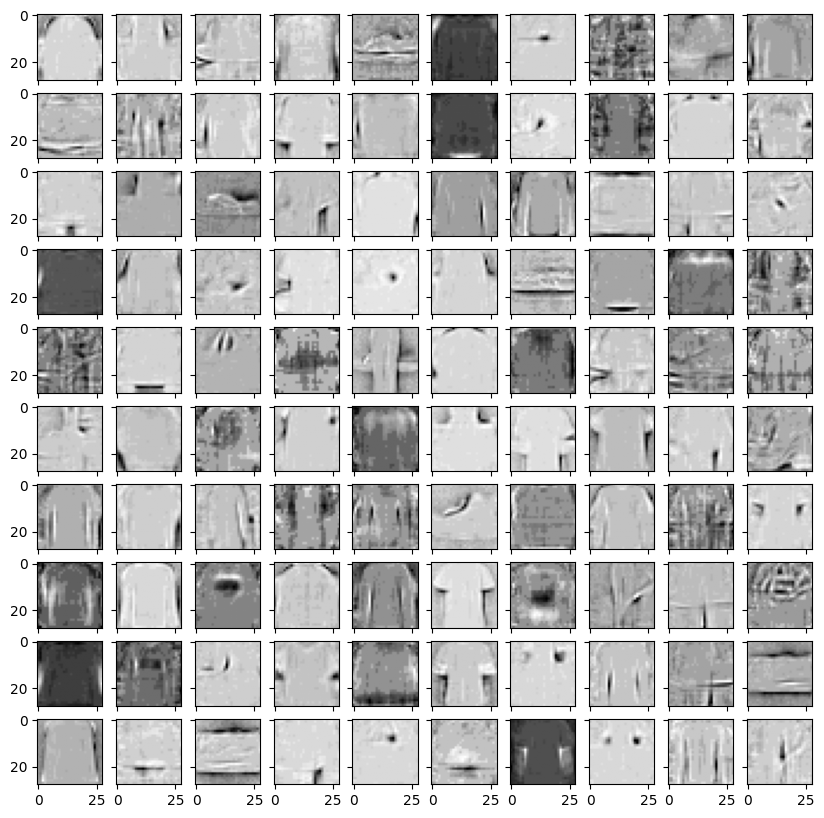

In [33]:
#1st layer
w1 = get_weights(dbn, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

The network seems to be capturing basic patterns like edges, corners, and simple textures as well as textures and silhouettes

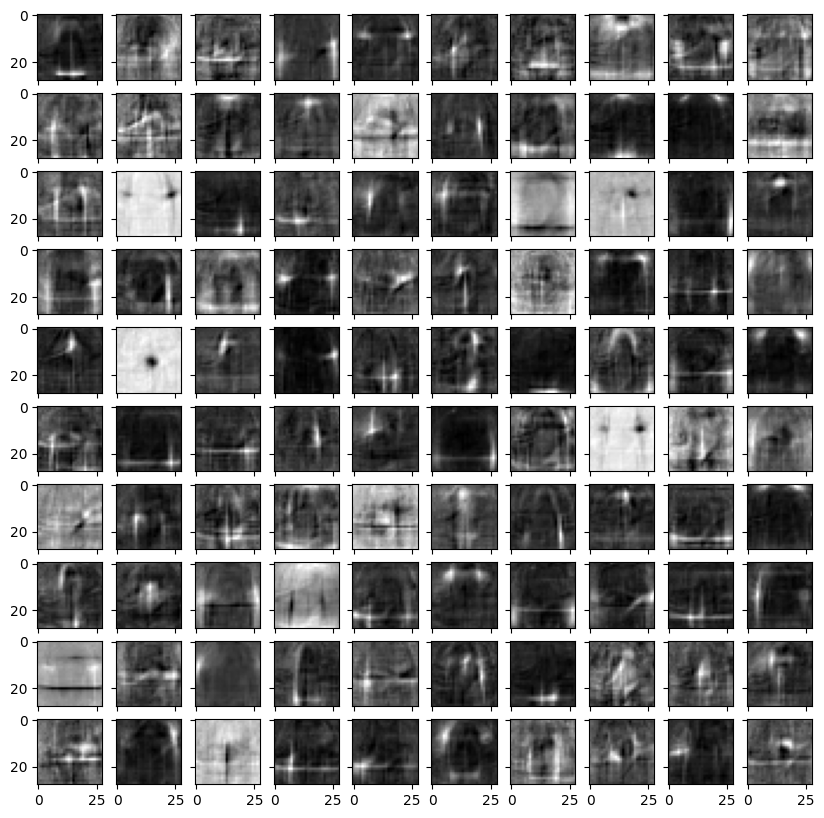

In [ ]:
#2nd layer
w1 = get_weights(dbn, layer=0)
w2 = get_weights(dbn, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)


The model focuses on more complex combinations of features and its harder to interpret

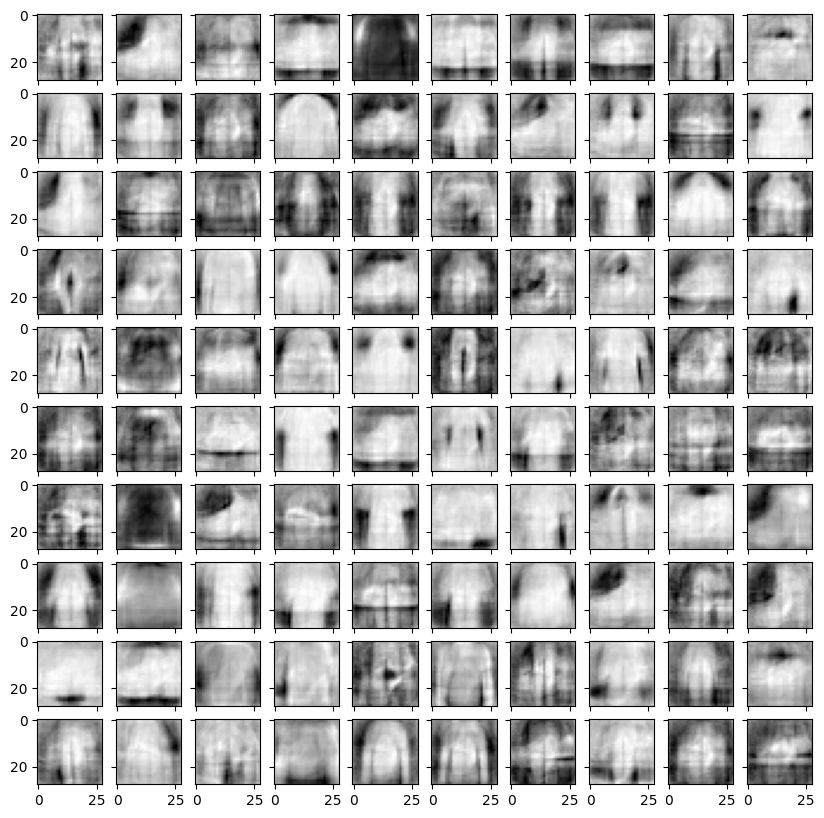

In [ ]:
#3rd layer
w1 = get_weights(dbn, layer=0)
w2 = get_weights(dbn, layer=1)
w3 = get_weights(dbn, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

##Clustering internal representations

In [14]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [15]:
hidden_repr_1 = get_kth_layer_repr(mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 500])
torch.Size([60000, 600])
torch.Size([60000, 900])


In [16]:
def get_mask(label):  # we use this function to filter by class
  labels = mnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [17]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [18]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

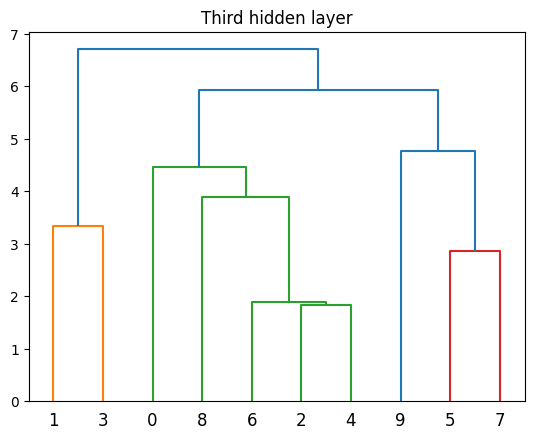

In [19]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

This result was forseeable. The classes are:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot


Classes 5,7,9 are classes corresponding to footwear. They are clustered together.

The model also has trouble differenciating between different types of topwear which also could be a difficult task for a human. It also has trouble differenciating between trousers and dress

## Linear read-outs

In [20]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr
hidden_repr_1 = get_kth_layer_repr(mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [21]:
layer_size = dbn.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [22]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = mnist_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))


In [23]:
train_linear(linear1, hidden_repr_1)

epoch :   1/1000, loss = 2.2937
epoch : 101/1000, loss = 0.8831
epoch : 201/1000, loss = 0.7049
epoch : 301/1000, loss = 0.6312
epoch : 401/1000, loss = 0.5877
epoch : 501/1000, loss = 0.5579
epoch : 601/1000, loss = 0.5356
epoch : 701/1000, loss = 0.5181
epoch : 801/1000, loss = 0.5039
epoch : 901/1000, loss = 0.4920


In [24]:
train_linear(linear2, hidden_repr_2)

epoch :   1/1000, loss = 2.3074
epoch : 101/1000, loss = 0.8010
epoch : 201/1000, loss = 0.6528
epoch : 301/1000, loss = 0.5896
epoch : 401/1000, loss = 0.5514
epoch : 501/1000, loss = 0.5249
epoch : 601/1000, loss = 0.5051
epoch : 701/1000, loss = 0.4895
epoch : 801/1000, loss = 0.4768
epoch : 901/1000, loss = 0.4663


In [25]:
train_linear(linear3, hidden_repr_3)

epoch :   1/1000, loss = 2.2710
epoch : 101/1000, loss = 0.8290
epoch : 201/1000, loss = 0.6614
epoch : 301/1000, loss = 0.5936
epoch : 401/1000, loss = 0.5540
epoch : 501/1000, loss = 0.5269
epoch : 601/1000, loss = 0.5068
epoch : 701/1000, loss = 0.4911
epoch : 801/1000, loss = 0.4784
epoch : 901/1000, loss = 0.4678


In [26]:
hidden_repr_1_test = get_kth_layer_repr(mnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [27]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [28]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [29]:
compute_accuracy(predictions_test1, mnist_te.targets)

0.8290999531745911

In [30]:
compute_accuracy(predictions_test2, mnist_te.targets)

0.8346999883651733

In [31]:
compute_accuracy(predictions_test3, mnist_te.targets)

0.8348999619483948

##Psychometric curves

In [34]:
def inject_noise(fashion_mnist_data, noise_level):
    # Generate Gaussian noise with the same shape as the input data
    noise = torch.randn_like(fashion_mnist_data) * noise_level

    # Add noise to the data
    noisy_data = fashion_mnist_data + noise

    # Clip the data to be in the valid range [0, 1]
    noisy_data = torch.clamp(noisy_data, 0.0, 1.0)

    return noisy_data


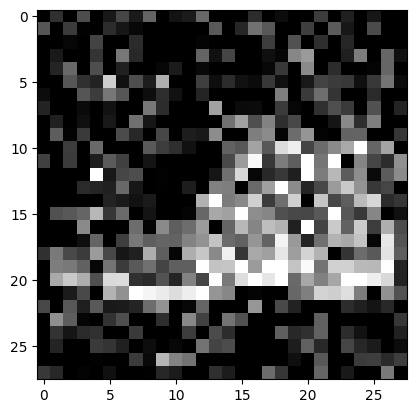

In [35]:
noise_level = 0.3
mnist_test_with_noise = inject_noise(mnist_te.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

In [36]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(mnist_te.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, mnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, mnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, mnist_te.targets)



  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden

In [37]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])


Accuracy of H1 read-out: 0.475
Accuracy of H2 read-out: 0.506
Accuracy of H3 read-out: 0.372


In [38]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []


  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])


  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)


  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden"])

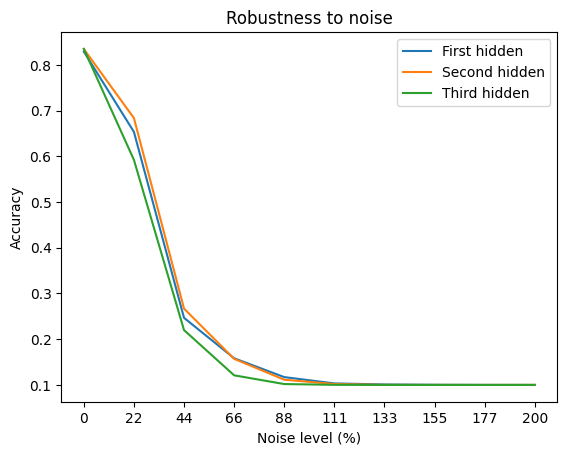

In [39]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

First hidden layer starts with a initial accuracy of about 80% and shows a gradual decline as noise increases, same can be said about second one but it demonstrates better noise robustness at higher noise levels compared to the first hidden layer. The third layer, unexpectedly, seems to degrade faster than the first and second layers. This degradation becames more visible after noise reaches 44%.

However, at very high noise levels, all layers converge to a similar accuracy (~10%, which is random guessing), highlighting that no layer is entirely immune to noise.

## Adversarial attack

In [41]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [42]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readout):
        super().__init__()
        self.readout = readout
        self.readout_level = 2
        self.dbn_mnist = dbn_mnist
        self._require_grad()

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readout.forward(hidden_states[self.readout_level])

In [43]:
dbn_with_readout = DBNWithReadOut(dbn, linear3)

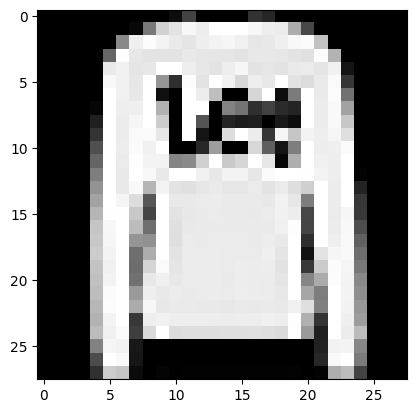

In [44]:
test_sample_idx = 1
test_image = mnist_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap = 'gray')

In [45]:
attacked_model = dbn_with_readout

In [46]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


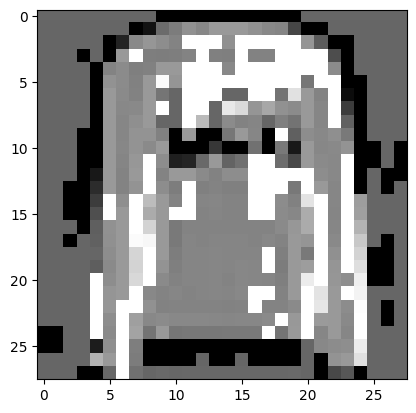

In [47]:
epsilon = 0.4  # define strenght of the attack
test_image_label = mnist_te.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward(retain_graph=True)
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np =  perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28), cmap = 'gray')



In [48]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 8.


## Resisting to adversarial attacks

In [49]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0  # count number of correct classifications
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, show the resulting image

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)  # forward pass through the model

        init_pred = torch.argmax(output)  # prediction before the attack

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss_value = torch.nn.functional.cross_entropy(output, target) # get loss value
        model.zero_grad()
        loss_value.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # call the attack function previously defined

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        # If requested, reconstruct the input iterating bottom-up and top-down sampling
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [50]:
from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True
)


In [51]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

100%|██████████| 100/100 [00:01<00:00, 60.48it/s]


Epsilon: 0.2
Test Accuracy: 13.42%



  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



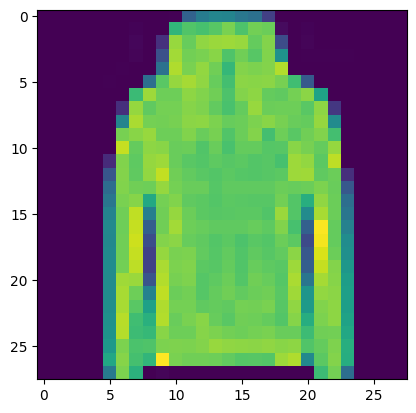


Here's a perturbed sample:



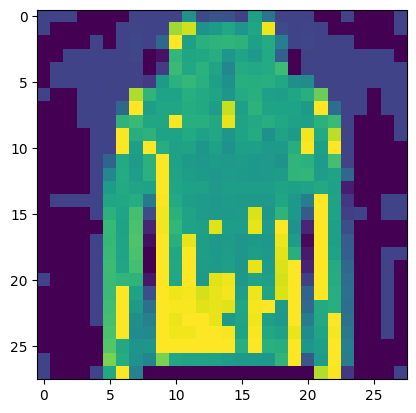


Here's what a 2-steps reconstructed sample looks like:



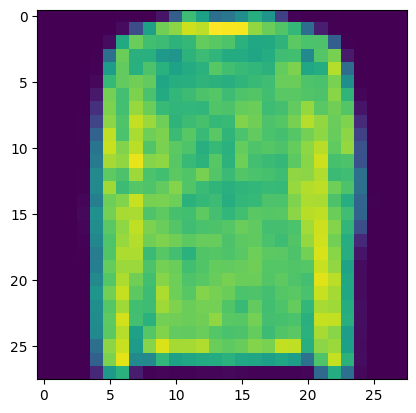

100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Epsilon: 0.2
Test Accuracy: 13.47%



In [52]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=2)

In [53]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [54]:
%%capture
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

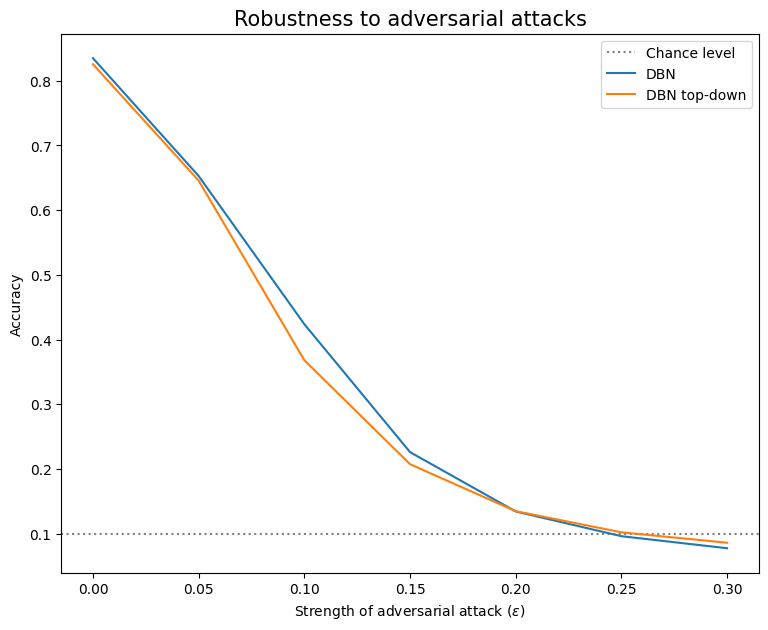

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "DBN", "DBN top-down"])

#CNN
I also implemented a CNN architecture since it is well-suited for image data like Fashion MNIST. CNNs leverage the spatial structure of images, so they are effective at learning features such as edges, textures, and patterns. For Fashion MNIST which involves images of clothing, CNNs should be particularly good at detecting textures, shapes, and spatial relationships. It will be interesting to see if the CNN can outperform the DBN in distinguishing between similar classes.

The CNN consists of three convolutional layers followed by max-pooling, batch normalization, and ReLU activations. The first layer uses 32 filters, the second 64 filters, and the third 128 filters, all with a 3x3 kernel size, stride of 1, and padding of 1. Max-pooling with a 2x2 kernel size is applied after each convolutional block to reduce spatial dimensions.The network transitions into fully connected layers.

For training, CrossEntropyLoss is used to handle multi-class classification, and the Adam optimizer with a learning rate of 0.001 minimizes the loss.The model is trained for 10 epochs.




## Training

In [57]:
train_loader = DataLoader(TensorDataset(mnist_tr.data.unsqueeze(1), mnist_tr.targets), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(mnist_te.data.unsqueeze(1), mnist_te.targets), batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Adjust size dynamically if needed
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.bn1(self.relu(self.conv1(x))))
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        x = self.pool(self.bn3(self.relu(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the CNN
num_epochs = 10
print("Training CNN on Fashion MNIST...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device).float(), labels.to(device)  # Move to device
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# Evaluate the CNN
print("Evaluating CNN on Test Data...")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device).float(), labels.to(device)  # Move to device
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Training CNN on Fashion MNIST...
Epoch 1/10, Loss: 377.3429, Accuracy: 85.46%
Epoch 2/10, Loss: 247.3254, Accuracy: 90.42%
Epoch 3/10, Loss: 211.9667, Accuracy: 91.76%
Epoch 4/10, Loss: 190.6142, Accuracy: 92.63%
Epoch 5/10, Loss: 173.2177, Accuracy: 93.25%
Epoch 6/10, Loss: 154.8910, Accuracy: 93.99%
Epoch 7/10, Loss: 142.8087, Accuracy: 94.44%
Epoch 8/10, Loss: 130.2817, Accuracy: 94.83%
Epoch 9/10, Loss: 120.9169, Accuracy: 95.32%
Epoch 10/10, Loss: 111.2010, Accuracy: 95.64%
Evaluating CNN on Test Data...
Test Accuracy: 92.42%


              precision    recall  f1-score   support

 T-shirt/top       0.88      0.88      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.92      0.89      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.87      0.88      0.88      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.82      0.74      0.78      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



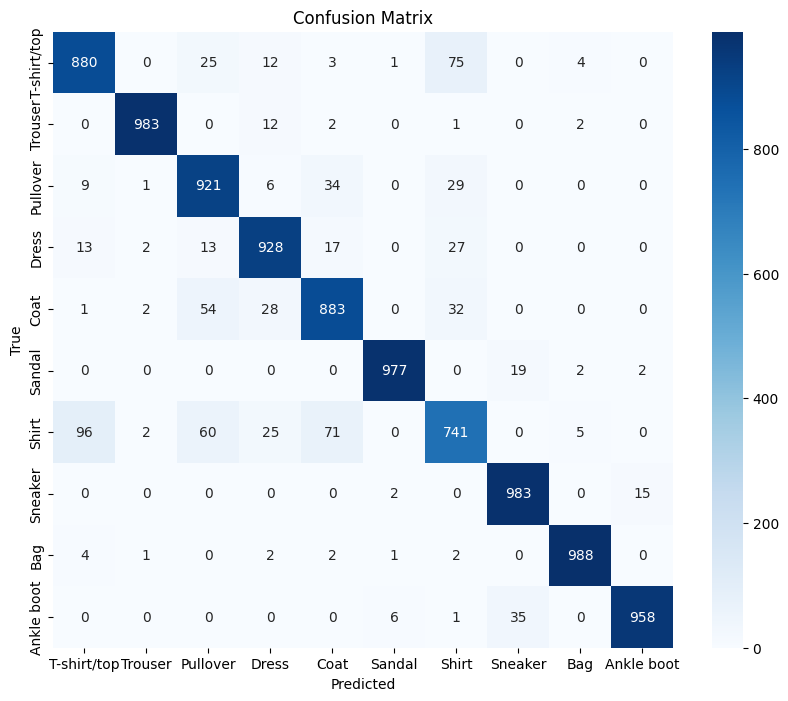

In [59]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def display_metrics_and_confusion_matrix(labels, preds, class_names):
    print(classification_report(labels, preds, target_names=class_names))
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


labels, preds = evaluate_model(model, test_loader, device)
display_metrics_and_confusion_matrix(labels, preds, class_names)


## Linear Readouts on convolutional layers

In [60]:
def get_layer_representation(model, layer_name, input_data):
    with torch.no_grad():
        for name, module in model.named_children():
            input_data = module(input_data)
            if name == layer_name:
                return input_data.view(input_data.size(0), -1)

class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)


# Initialize the CNN and freeze its layers
cnn = CNN().to(device)
cnn.eval()  # Set CNN to evaluation mode

# Define the convolutional layers for feature extraction
conv_layers = ["conv1", "conv2", "conv3"]

# Dictionary to store results for each layer
results = {}

for layer_name in conv_layers:
    print(f"Training Linear Readout for Layer: {layer_name}")

    # Extract a sample feature to determine input size
    sample_data, _ = next(iter(train_loader))
    sample_data = sample_data.to(device)
    feature_sample = get_layer_representation(cnn, layer_name, sample_data)
    input_size = feature_sample.size(1)

    # Initialize the linear classifier
    linear_model = LinearClassifier(input_size=input_size, num_classes=10).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linear_model.parameters(), lr=0.001)

    # Train the linear classifier
    num_epochs = 10
    for epoch in range(num_epochs):
        linear_model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Extract features from the chosen CNN layer
            features = get_layer_representation(cnn, layer_name, images)

            # Forward pass through linear model
            outputs = linear_model(features)
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Evaluate the linear classifier
    print(f"Evaluating Linear Readout for Layer: {layer_name}")
    linear_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = get_layer_representation(cnn, layer_name, images)
            outputs = linear_model(features)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Linear Readout Accuracy for Layer {layer_name}: {test_accuracy:.2f}%")

    # Store the results for the layer
    results[layer_name] = test_accuracy

# Display final results for all layers
print("\nFinal Linear Readout Results:")
for layer, acc in results.items():
    print(f"Layer {layer}: Test Accuracy = {acc:.2f}%")


Training Linear Readout for Layer: conv1
Epoch 1/10, Loss: 629.7540, Accuracy: 79.29%
Epoch 2/10, Loss: 609.4397, Accuracy: 81.44%
Epoch 3/10, Loss: 594.7073, Accuracy: 82.10%
Epoch 4/10, Loss: 595.1053, Accuracy: 82.30%
Epoch 5/10, Loss: 625.4547, Accuracy: 81.86%
Epoch 6/10, Loss: 613.7479, Accuracy: 82.28%
Epoch 7/10, Loss: 596.5733, Accuracy: 82.54%
Epoch 8/10, Loss: 615.7014, Accuracy: 82.40%
Epoch 9/10, Loss: 587.9128, Accuracy: 82.84%
Epoch 10/10, Loss: 592.4067, Accuracy: 82.84%
Evaluating Linear Readout for Layer: conv1
Linear Readout Accuracy for Layer conv1: 78.15%
Training Linear Readout for Layer: conv2
Epoch 1/10, Loss: 659.5834, Accuracy: 78.86%
Epoch 2/10, Loss: 622.7006, Accuracy: 81.29%
Epoch 3/10, Loss: 621.6923, Accuracy: 81.69%
Epoch 4/10, Loss: 640.8406, Accuracy: 81.73%
Epoch 5/10, Loss: 629.2287, Accuracy: 82.21%
Epoch 6/10, Loss: 634.7264, Accuracy: 82.00%
Epoch 7/10, Loss: 639.9391, Accuracy: 82.18%
Epoch 8/10, Loss: 657.1987, Accuracy: 82.28%
Epoch 9/10, Loss

The CNN I used has lower linear readout accuracy compared to the DBN. The possible explanation could be in the fact how two models learn and represent features. CNNs are designed to learn localized and task-specific features using convolutional layers. These features work well for capturing spatial patterns like edges and textures, but they are not always organized in a way that makes them easily separable with a linear classifier.On the other hand, DBNs learn global representations through layer-by-layer unsupervised pretraining. This approach helps create more distinct and clustered features, which are easier to separate with a linear classifier.

## Visualizing Filters and Clustering internal representations

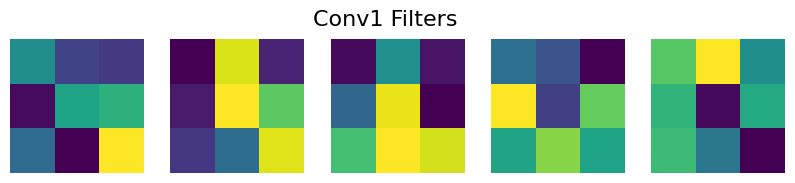

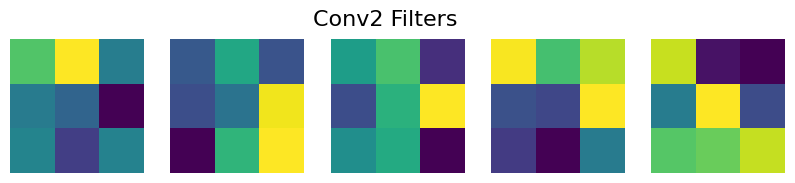

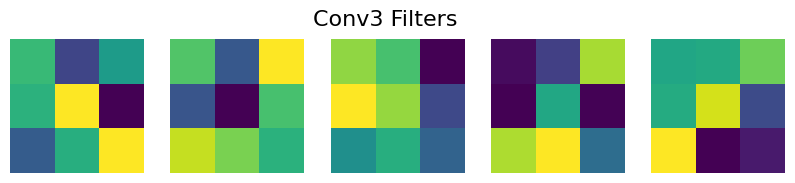

In [64]:
def visualize_filters(layer_weights, num_filters=8, title="Filter Receptive Fields"):
    # Get the weights of the filters
    filters = layer_weights.cpu().detach().numpy()

    min_val, max_val = filters.min(), filters.max()
    filters = (filters - min_val) / (max_val - min_val)

    fig, axes = plt.subplots(1, num_filters, figsize=(10, 2))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes):
        if i < filters.shape[0]:
            ax.imshow(filters[i, 0], cmap="viridis")
            ax.axis("off")
    plt.show()

cnn.eval()

# Conv1 filters
conv1_weights = cnn.conv1.weight
visualize_filters(conv1_weights, num_filters=5, title="Conv1 Filters")

# Conv2 filters
conv2_weights = cnn.conv2.weight
visualize_filters(conv2_weights, num_filters=5, title="Conv2 Filters")

# Conv3 filters
conv3_weights = cnn.conv3.weight
visualize_filters(conv3_weights, num_filters=5, title="Conv3 Filters")


These are the receptive fields (filters) from 3 conv layers. Each grid represents the weights of one filter in the layer. Similarly as in DBN filters in first layer learn more basic patterns such as edges, gradients and so on, while the filters on subsequent layers are harder to interpret.

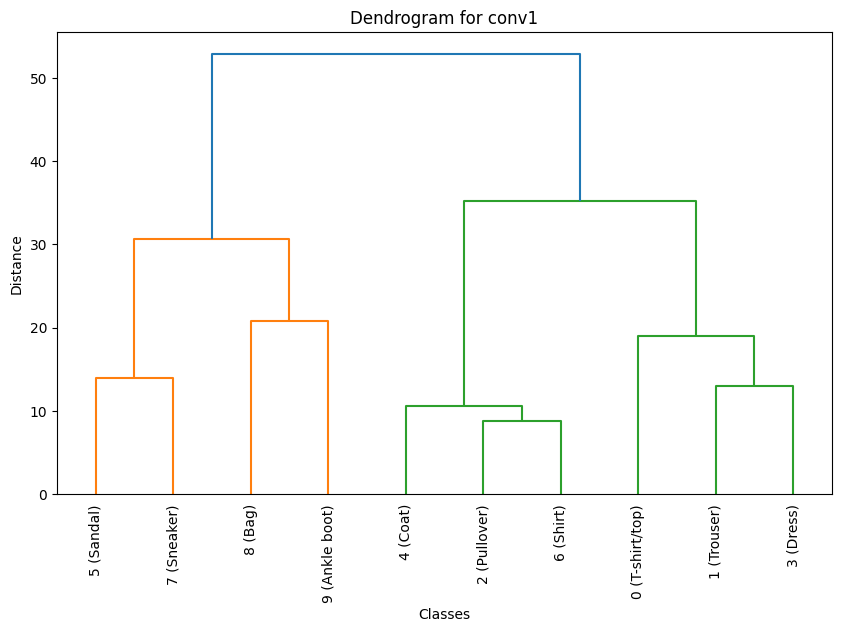

In [93]:
from scipy.cluster.hierarchy import dendrogram, linkage

def generate_classwise_dendrogram(model, layer_name, dataloader, num_samples=1000, method='ward'):
    # Define the mapping of class numbers to their meanings
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    class_features = {}
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Extract features for the selected layer
            layer_features = get_layer_representation(model, layer_name, images)
            layer_features = layer_features.cpu().numpy()  # Move to CPU and convert to NumPy

            # Group features by class
            for feature, label in zip(layer_features, labels.cpu().numpy()):
                if label not in class_features:
                    class_features[label] = []
                class_features[label].append(feature)

            if sum(len(v) for v in class_features.values()) >= num_samples:
                break

    averaged_features = []
    class_labels = []
    for label, features in class_features.items():
        averaged_features.append(np.mean(features, axis=0))  # Compute the mean for each class
        class_labels.append(label)

    # Perform hierarchical clustering
    linkage_matrix = linkage(averaged_features, method=method)

    plt.figure(figsize=(10, 6))
    dendrogram(
        linkage_matrix,
        labels=[f"{cls} ({class_names[cls]})" for cls in class_labels],
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=0.7 * max(linkage_matrix[:, 2])
    )
    plt.title(f"Dendrogram for {layer_name}")
    plt.xlabel("Classes")
    plt.ylabel("Distance")
    plt.show()


generate_classwise_dendrogram(
    model=cnn,
    layer_name="conv1",
    dataloader=train_loader,
    num_samples=1000,
    method='ward'
)


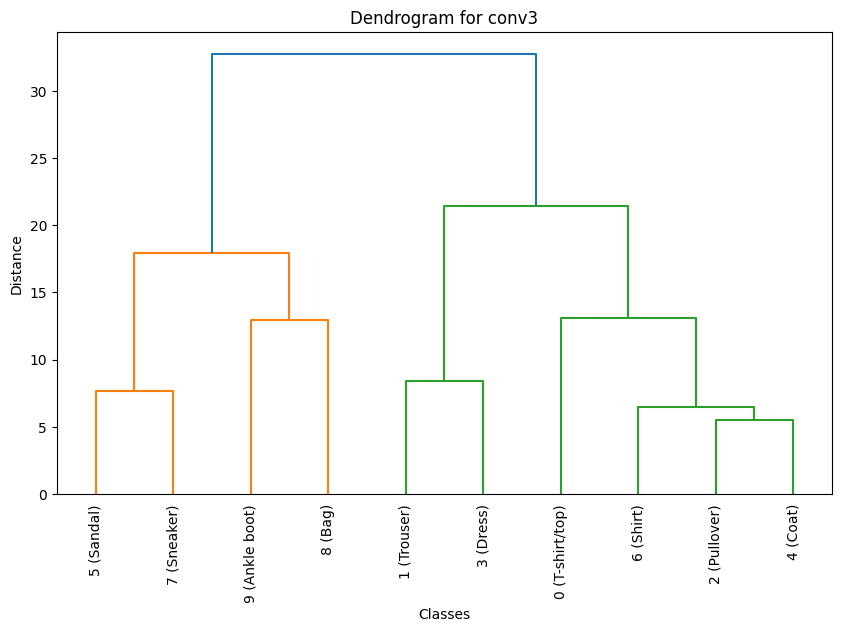

In [92]:
generate_classwise_dendrogram(
    model=cnn,
    layer_name="conv3",
    dataloader=train_loader,
    num_samples=1000,
    method='ward'
)

In the Conv1 dendrogram, we see the representations learned by the first CNN layer.At this stage, the features are very basic, like edges and textures. This is why similar classes, such as 7, 5, 9, and 8, are grouped together. Other classes, like 6, 2, 4, 0, 1, and 3, are grouped more broadly. The distances on the y-axis are relatively high, showing that the features are still general and not very distinctive, which makes sense for an early layer.

The Conv3 dendrogram represents the third CNN layer, where the features become more refined and specific to the task. The same grouping of 7, 5, 9, and 8 is present, but the distances are smaller, meaning the network is better at distinguishing between classes. The deeper layer is learning more detailed and task-relevant features, which makes the clusters better separated.

If the compare this dendograms to the DBN one, we can see that CNN has a better performance. There, classes like 1 and 3 and 9 and 5 cluster tightly, but the overall distances are much smaller than in the CNN. This indicates that the DBN’s representations are less distinct and overlap more. DBN has limited ability in separating classes



## Psychometric curves

Epoch 1/5, Loss: 471.2520
Epoch 2/5, Loss: 342.1618
Epoch 3/5, Loss: 308.9996
Epoch 4/5, Loss: 291.6936
Epoch 5/5, Loss: 278.1990
Epoch 1/5, Loss: 1353.6726
Epoch 2/5, Loss: 832.7334
Epoch 3/5, Loss: 690.9892
Epoch 4/5, Loss: 621.8177
Epoch 5/5, Loss: 578.5720
Plotting noise robustness...


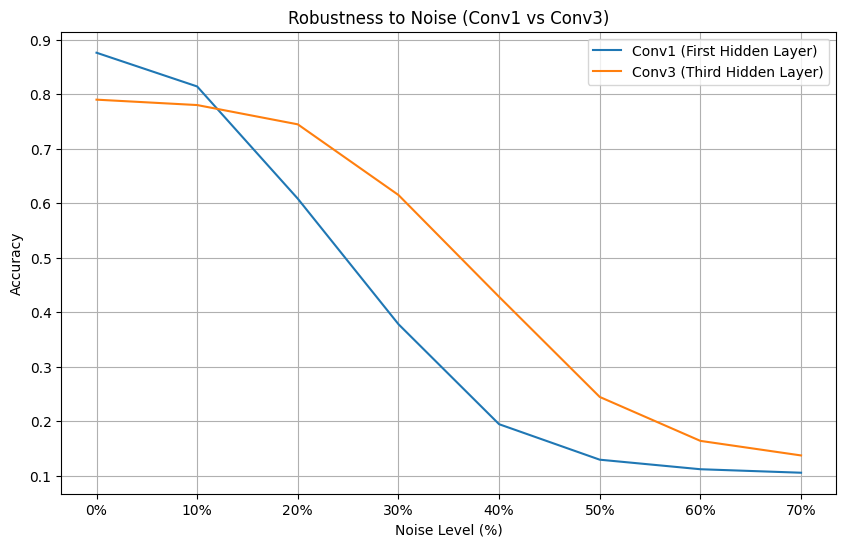

In [104]:
def get_layer_representation(model, input_data, layer_name):
    with torch.no_grad():
        if layer_name == "conv1":
            x = model.conv1(input_data)
            x = model.pool(model.relu(model.bn1(x)))  # Apply activation, batch norm, and pooling
        elif layer_name == "conv3":
            x = model.conv1(input_data)
            x = model.pool(model.relu(model.bn1(x)))
            x = model.conv2(x)
            x = model.pool(model.relu(model.bn2(x)))
            x = model.conv3(x)
            x = model.pool(model.relu(model.bn3(x)))
        else:
            raise ValueError("Invalid layer name. Use 'conv1' or 'conv3'.")
        return x.view(x.size(0), -1)  # Flatten the output

# Train linear model
def train_linear_model(model, linear_model, layer_name, train_loader, device, epochs=5):
    model.eval()  # Ensure CNN is in evaluation mode
    linear_model.train()  # Set the linear model to training mode

    optimizer = optim.Adam(linear_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Extract features from the specified layer
            layer_repr = get_layer_representation(model, images, layer_name)

            # Forward pass through the linear model
            predictions = linear_model(layer_repr)
            loss = criterion(predictions, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Compute accuracy at different noise levels
def get_accuracy_values_at_noise_level(model, linear_model, noise_level, test_loader, layer_name, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Inject noise into the test images
        noisy_images = inject_noise(images, noise_level)

        # Get representation for the specified layer
        layer_repr = get_layer_representation(model, noisy_images, layer_name)

        # Evaluate using the linear classifier
        predictions = linear_model(layer_repr)
        total_correct += (predictions.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

# Plot noise robustness
def plot_noise_robustness(model, linear_models, noise_levels, test_loader, device):
    accuracy_values = {"conv1": [], "conv3": []}

    # Compute accuracy for each noise level
    for noise_level in noise_levels:
        acc_conv1 = get_accuracy_values_at_noise_level(model, linear_models["conv1"], noise_level, test_loader, "conv1", device)
        acc_conv3 = get_accuracy_values_at_noise_level(model, linear_models["conv3"], noise_level, test_loader, "conv3", device)
        accuracy_values["conv1"].append(acc_conv1)
        accuracy_values["conv3"].append(acc_conv3)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, accuracy_values["conv1"], label="Conv1 (First Hidden Layer)")
    plt.plot(noise_levels, accuracy_values["conv3"], label="Conv3 (Third Hidden Layer)")
    plt.title("Robustness to Noise (Conv1 vs Conv3)")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("Accuracy")
    plt.xticks(noise_levels, [f"{int(l*100)}%" for l in noise_levels])
    plt.legend()
    plt.grid(True)
    plt.show()


linear_models = {
    "conv1": nn.Linear(32 * 14 * 14, 10).to(device),  # Input size matches Conv1 representation
    "conv3": nn.Linear(128 * 3 * 3, 10).to(device)   # Input size matches Conv3 representation
}

train_linear_model(cnn, linear_models["conv1"], "conv1", train_loader, device, epochs=5)
train_linear_model(cnn, linear_models["conv3"], "conv3", train_loader, device, epochs=5)

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# Plot noise robustness
print("Plotting noise robustness...")
plot_noise_robustness(cnn, linear_models, noise_levels, test_loader, device)


Conv1 starts with the highest accuracy at 0% noise (\~90\%) but drops sharply as noise increases. At noise levels beyond 40%, accuracy declines rapidly and becomes negligible by 70%.
Con3 seems more robust to noise compared to Conv1, maintaining accuracy better up to ~30%. However, both layers show significant decrease as noise increases, demonstrating that CNN representations are not inherently noise-resilient.

As compared to the DBN, the CNN starts with slightly better initial accuracy for all layers but CNN’s accuracy drops rapidly, especially for Conv1, while the DBN shows a smoother decline and DBN's layers retain higher robustness to noise compared to CNN’s Conv3.
This suggests that for tasks involving noisy or uncertain input data, the DBN may provide more stable representations.

